Acceleromter Stuff
====
Initial exploration

### Prerequisites
The right version of python and various packages and probably a GPU

### where the data is
I've copied a single accelerometer file into the `data/` directory to do this initial exploration.

This isn't a viable long-term solution, but downloading from RDSF takes forever

I've also mounted the RDSF files on my `Z:` drive - change this in `userconf.yaml` if you've done something different

One can also mount the files in the right place with
```
sudo mount -t cifs -o username=mh19137,workgroup=UOB //rdsfcifs.acrc.bris.ac.uk/SEACOCH20 /mnt/z/
```

### Choose a participant

Find the relevant meal times and accelerometry data for this person

In [1]:
device_id = "6012582"
recording_id = "0000291121"
participant_id = "20029"

In [4]:
from ema import read

meal_no = 10  # This one seems reasonable (some are before the start of the accelerometer recording)
samples = read.get_participant_meal(device_id, recording_id, participant_id, meal_no)

Discarding: {'Catch-up end': 1, 'Catch-up start': 1, 'No catch-up': 2, 'No response': 72}
Kept: {'Drink': 35, 'Meal': 37, 'No food/drink': 4, 'Snack': 2}


### Explore some of the time series data
We'll choose one of the meals and look at the acceleration data for the preceeding hour.

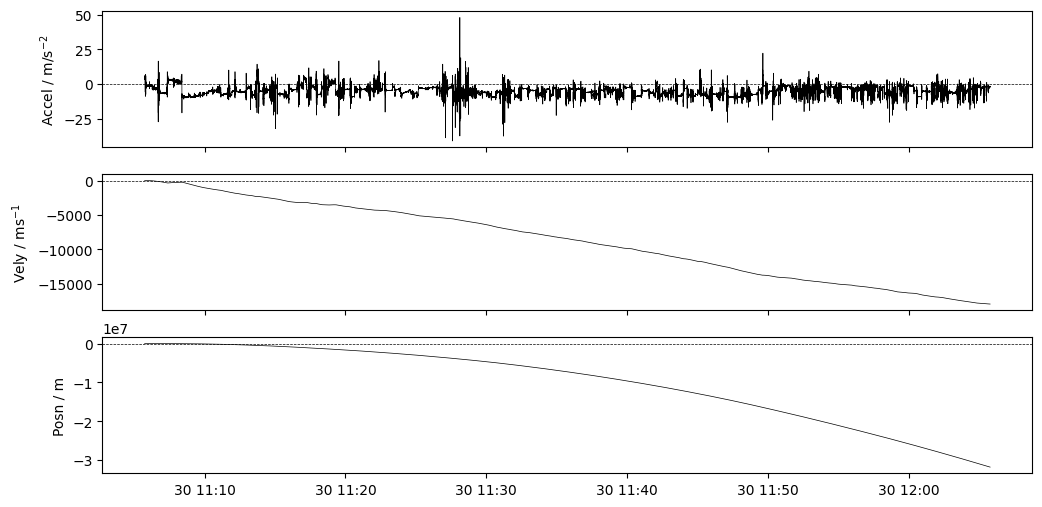

In [5]:
# Slice the series to only include accelerations in an hour preceeding a meal
import numpy as np
import matplotlib.pyplot as plt

from ema import plotting, analysis, util

# Get the acceleration in one dimension
accel = samples["accel_x"]
vely = analysis.integrate(accel, dx=1 / util.SAMPLE_RATE_HZ)
posn = analysis.integrate(vely, dx=1 / util.SAMPLE_RATE_HZ)

plotting.plot_integrals(accel.index, [accel, vely, posn])

### There's a big drift in the integrated velocity and positions!

This is because the accelerometer often doesn't tare around 0 - it stabilises around a value that is small but not zero. This is a problem for us, since it means when we integrate our speed and position just get larger and larger...

We can try two things to get rid of this:
 - 1: Take a moving average and subtract it from the signal
 - 2: Apply a low-pass filter

#### Moving Average
I've explored two ways to take the moving average:
 - directly
 - with a convolution

#### Low Pass Filter
One can also take the Fourier transform of the signal, remove low-frequency components and transform again to recover the original signal with the slowly-moving parts removed.


We'll try all of these below.

In [7]:
# First we'll do some simple processing
# Remove the mean value of the acceleration from the time series
# This will also remove gravity (if that's a constant addition)

accel -= np.mean(accel)

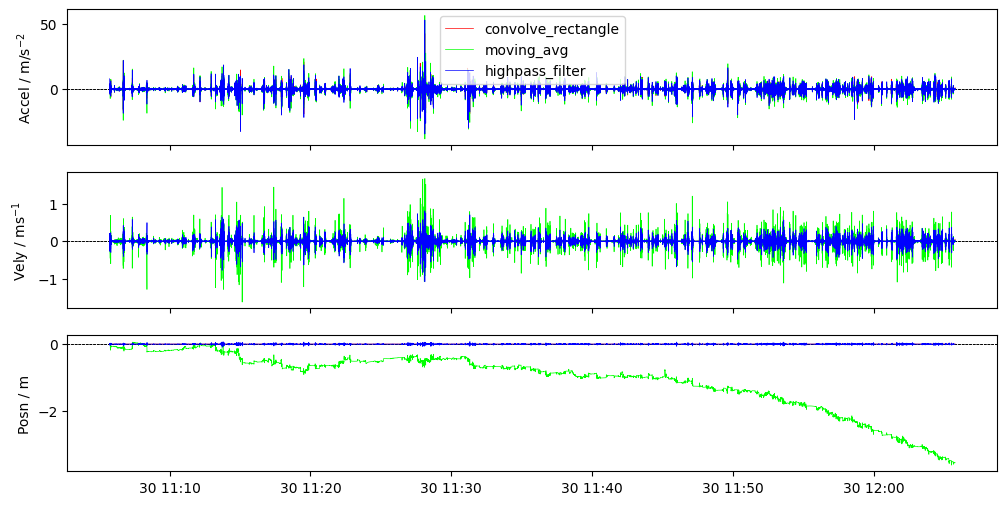

In [8]:
# Remove the low frequencies from the acceleration
from typing import Callable

from ema import smooth


fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True)


def plot_pts(fcn: Callable, colour: str, linewidth: float, **kwargs) -> None:
    """
    Smooth the acceleration with fcn, integrate twice to get vely + position, plot
    on the figure

    Using the given colour

    kwargs passed to fcn

    """
    smoothed_accel = fcn(accel, **kwargs)

    vely = analysis.integrate(smoothed_accel, dx=1 / util.SAMPLE_RATE_HZ)

    # Smooth also the velocity
    vely = fcn(vely, **kwargs)

    posn = analysis.integrate(vely, dx=1 / util.SAMPLE_RATE_HZ)

    plotting.plot_integrals(
        accel.index,
        [smoothed_accel, vely, posn],
        fig=fig,
        color=colour,
        label=fcn.__name__,
    )


# This one might be ok
plot_pts(smooth.convolve_rectangle, "#ff0000", linewidth=0.5, width=10)
plot_pts(smooth.moving_avg, "#00ff00", linewidth=0.4, width=25)
plot_pts(smooth.highpass_filter, "#0000ff", linewidth=0.3, order=3, critical_freq=1.0)

axes[0].legend()

### The moving average clearly doesn't work as well as the others

So let's just plot them

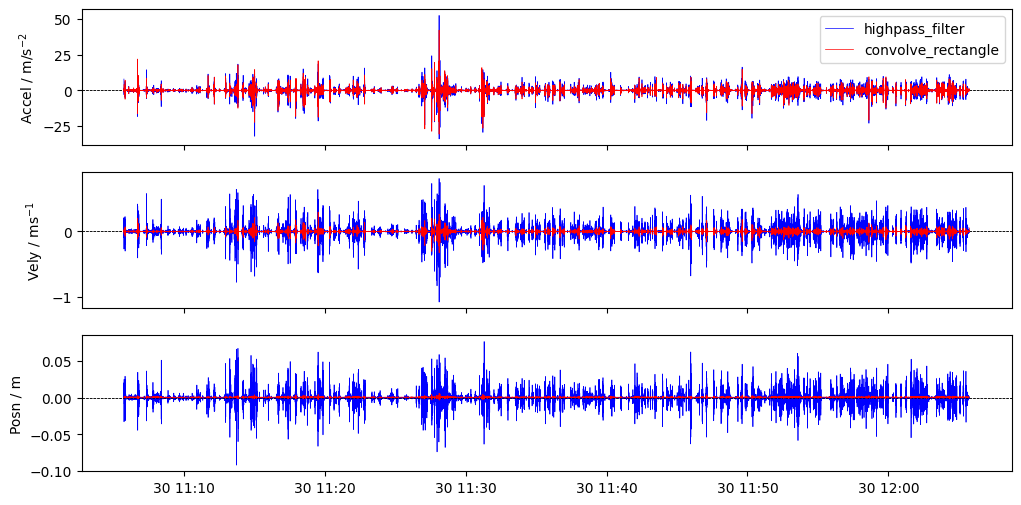

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True)

# This one might be ok
plot_pts(smooth.highpass_filter, "#0000ff", linewidth=0.3, order=3, critical_freq=1.0)
plot_pts(smooth.convolve_rectangle, "#ff0000", linewidth=0.5, width=10)

axes[0].legend()

### It looks like the high-pass filter has the best performance
The convolution method looks like it might be getting rid of a lot of signal

But we can try it anyway in our future analysis